In [1]:
# import all the modules; also should re-define all the essential functions here before moving them to the library. 
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm

from utils import *

import matplotlib as mpl

In [2]:
# co-utilizers with D=100
N_community = 10000
logD = log(100)
gC = 1.5
# introduce new param rho
rho_list = [0.20685342671335671, 0.21360680340170085, 0.22771385692846424, 0.235967983991996, 0.239719859929965]
data = []
for R in range(2, 7):
    N = R
    rho_mean = rho_list[R-2]
    communities = []
    stabilities = []
    for i in tqdm(range(N_community)):
        community = {}
        g_enz = generate_g(N, R) # enzyme properties, not real growth rates
        dep_orders = np.array(list(itertools.permutations(list(range(1, R+1)))))
        N_dep_order = len(dep_orders)
        rhos = rho_mean * np.ones(N)
        community["g"] = g_enz
        community["rho"] = rhos
        community["N_dep_orders"] = N_dep_order # allowed number of depletion orders, regardless of growth rates
        community["allowed_orders"] = dep_orders
        community["possible_orders"] = []
        for j in range(N_dep_order):
            dep_order = dep_orders[j]
            G = G_mat_cout_hwa(g_enz, gC, dep_order, rhos) # here assume all species have same rho
            if(np.linalg.matrix_rank(G)>=N):
                t = np.linalg.inv(G)@np.ones(R)*logD
                if(sum(t>0) >= len(t)):
                    community["possible_orders"].append(dep_order)
        communities.append(community)
    data.append({"R":R, "logD":logD, "gC": gC, "communities":communities})
filename = "../data/cout_hwa_D=100_diagonal_2_6_rho_0213.pkl"
pickle.dump(data, open(filename, "wb"))

100%|██████████| 10000/10000 [43:02<00:00,  3.87it/s] 


In [4]:
data = {}
N_community = 10000
# coutilizer
data["cout_hwa"] = [[], []]
filename = "../data/cout_hwa_D=100_diagonal_2_6_rho_0213.pkl"
data_sub = pickle.load(open(filename, "rb"))
for R in range(2, 7):
    N = R
    communities = []
    stabilities = []
    stable = 0
    feasible = 0
    for item in data_sub:
        if(item["R"]==R):
            communities = item["communities"]
            break
    logD, gC = item["logD"], item["gC"]
    for item in communities[:N_community]:
        if(item["possible_orders"]!=[]):
            for order in item["possible_orders"]:
                g_enz, dep_order, rhos = item["g"], order, item["rho"]
                G = G_mat_cout_hwa(g_enz, gC, dep_order, rhos)
                t = np.linalg.inv(G)@np.ones(R)*logD
                F = F_mat_cout_hwa(g_enz, G, dep_order, logD)
                env = {"N":N, "R":R, "logD":logD}
                feasible += 1
                if(np.abs(np.max(np.real(np.linalg.eigvals(Pert_mat_cout_hwa(g_enz, list(dep_order), G, t, F, env))))) < 1+1e-9):
                    stabilities.append( (log(np.abs(np.linalg.det(F))/(exp(logD)-1)**R)/log(10))/(R-1) )
                    stable += 1
                    break
    feasibility = feasible/N_community
    success_rate = stable/N_community
    stability = np.mean(stabilities)
    err = np.std(stabilities)/sqrt(len(stabilities))
    data["cout_hwa"][0].append([feasibility, success_rate])
    data["cout_hwa"][1].append([stability, err])
print(data["cout_hwa"])

[[[0.5078, 0.5078], [0.2591, 0.259], [0.127, 0.127], [0.0625, 0.0625], [0.0303, 0.0301]], [[-1.8200799525995934, 0.01100262880610549], [-1.893021165101588, 0.010210390337879682], [-1.9370160821433449, 0.012075383356045523], [-1.9818543924643688, 0.013636104507055461], [-2.0036110310285338, 0.018121889715948414]]]


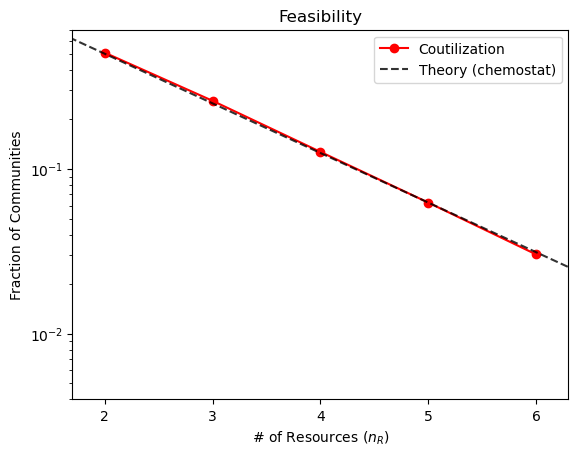

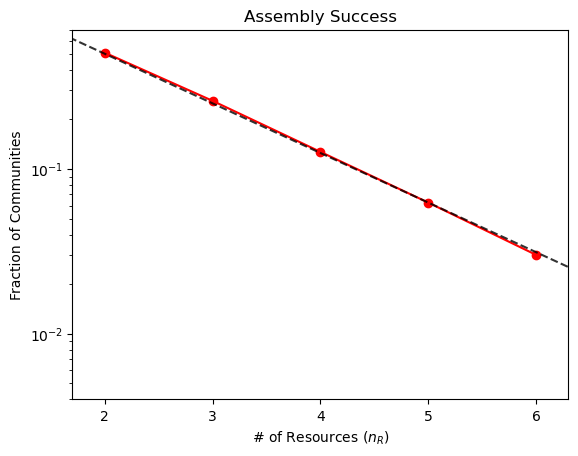

In [5]:
plt.plot(range(2, 7), [i[0] for i in data["cout_hwa"][0]], marker="o", color="r", alpha=1, label="Coutilization")
plt.yscale("log")
plt.xlabel("# of Resources ($n_R$)")
plt.ylabel("Fraction of Communities")
plt.xlim(1.7, 6.3)
plt.ylim(0.004, 0.7)
xspace = np.linspace(1, 7, 300)
yspace = 1/2**(xspace-1)
plt.plot(xspace, yspace, color='k', linestyle="--", alpha=0.8, label = "Theory (chemostat)")
plt.legend()
plt.title("Feasibility")
# plt.savefig("../figures/feasibility_plot.pdf")
plt.show()

plt.plot(range(2, 7), [i[1] for i in data["cout_hwa"][0]], marker="o", color="r", alpha=1, label="Coutilization")
plt.yscale("log")
plt.xlabel("# of Resources ($n_R$)")
plt.ylabel("Fraction of Communities")
plt.xlim(1.7, 6.3)
plt.ylim(0.004, 0.7)
xspace = np.linspace(1, 7, 300)
yspace = 1/2**(xspace-1)
plt.plot(xspace, yspace, color='k', linestyle="--", alpha=0.8, label = "Theory (chemostat)")
plt.title("Assembly Success")
# plt.legend()
# plt.savefig("../figures/assembly_success_plot.pdf")
plt.show()